# Quantum benchmark

## I - Introduction

## II - Packages

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import normalize
from sklearn.model_selection import cross_val_score, KFold
#Import classical libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import datasets
import matplotlib.pyplot as plt

plt.style.use('ggplot')

import functools

from qiskit import BasicAer
from qiskit.circuit.library import ZZFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.algorithms import QSVC
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit_machine_learning.datasets import ad_hoc_data
import logging

import pennylane as qml
from pennylane.templates.embeddings import AngleEmbedding, AmplitudeEmbedding
from pennylane.optimize import AdamOptimizer

from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit.library import TwoLocal, ZZFeatureMap
import qiskit

## III - Data 

In [50]:
# Read out CSV

df = pd.read_csv('UCI_Credit_Card.csv', sep=',')

In [3]:
%%script false --no-raise-error

import sweetviz as sv

#EDA using Autoviz
sweet_report = sv.analyze(df)

#Saving results to HTML file
sweet_report.show_html('sweet_report.html')

## IV - Modelisation

### Classical

In [51]:
df_labels = df['default.payment.next.month']
df.drop(['default.payment.next.month'],axis = 1,inplace = True)

In [52]:
X_train, X_test, y_train, y_test = train_test_split(df, df_labels, test_size=0.2, random_state=42)

### Decision Tree

In [6]:
decision_tree = DecisionTreeClassifier( random_state=42) #max_depth=2,

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)

In [7]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.81      0.82      4687
           1       0.37      0.40      0.39      1313

    accuracy                           0.72      6000
   macro avg       0.60      0.61      0.60      6000
weighted avg       0.73      0.72      0.73      6000



### RandomForest

In [8]:
classifier = RandomForestClassifier( random_state=42) #max_depth=2,

classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)

In [9]:
# Print the classification report and important metrics

print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.94      0.89      4687
           1       0.63      0.36      0.46      1313

    accuracy                           0.81      6000
   macro avg       0.74      0.65      0.67      6000
weighted avg       0.79      0.81      0.79      6000



### Logistic Regression

In [10]:
lr = LogisticRegression(max_iter=1000, random_state=42) #max_depth=2,

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

In [11]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4687
           1       0.00      0.00      0.00      1313

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.69      6000



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### SVM

In [12]:
svm = SVC( random_state=42) #max_depth=2,

svm.fit(X_train, y_train)
y_pred = svm.predict(X_test)

In [13]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      1.00      0.88      4687
           1       0.00      0.00      0.00      1313

    accuracy                           0.78      6000
   macro avg       0.39      0.50      0.44      6000
weighted avg       0.61      0.78      0.69      6000



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


---

## Quantum Approaches

In [14]:
np.unique(df_labels)

array([0, 1])

In [4]:
from sklearn.decomposition import NMF

In [8]:
from sklearn.preprocessing import MinMaxScaler

In [9]:
# Standardizing the features
x = MinMaxScaler().fit_transform(df)

In [5]:
nmf = NMF(n_components=2)

In [10]:
nmf.fit(x)

/opt/homebrew/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:1692: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


NMF(n_components=2)

In [12]:
df_nmf = nmf.transform(x)

In [13]:
nmf_df = pd.DataFrame(data = df_nmf
             , columns = ['principal component 1', 'principal component 2'])

In [15]:
nmf_df.head()

,principal component 1,principal component 2
0,0.057302,0.007514
1,0.057436,0.045956
2,0.057802,0.043258
3,0.057124,0.024666
4,0.000596,0.108430


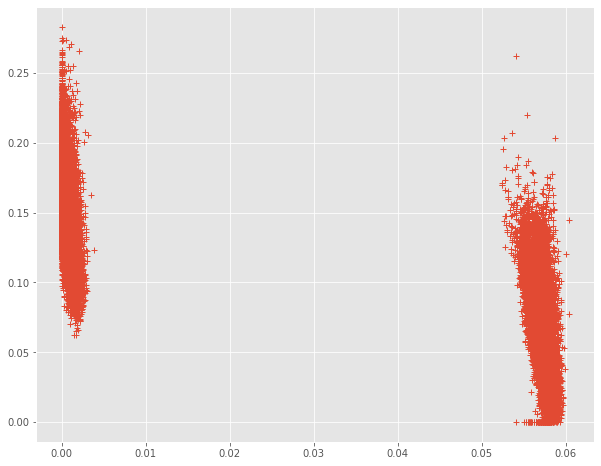

In [17]:
plt.figure(figsize=(10,8))
plt.plot(nmf_df.iloc[:,0], nmf_df.iloc[:,1], '+')
#plt.plot(df.index, feature_2, 'g+')

In [19]:
n_dim = len(nmf_df.columns)

## Split train test 

In [32]:
# Split dataset into train and test

sample_train, sample_test, label_train, label_test = train_test_split(
     nmf_df, df_labels, test_size=0.2, random_state=22)

# Normalize

'''std_scale = StandardScaler().fit(sample_train)
sample_train = std_scale.transform(sample_train)
sample_test = std_scale.transform(sample_test)

# Scale for better fit within the feature map

samples = np.append(sample_train, sample_test, axis=0)
minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
sample_train = minmax_scale.transform(sample_train)
sample_test = minmax_scale.transform(sample_test)

# Select a sample for a better control of the research and wall time
'''
train_size = 800#160
sample_train = sample_train[:train_size]
label_train = label_train[:train_size]

test_size = 200 #40
sample_test = sample_test[:test_size]
label_test = label_test[:test_size]

In [33]:
# Basic parameters for hybrid model

seed = 8500
feature_dim = n_dim
num_reps = 2
num_shots =256 


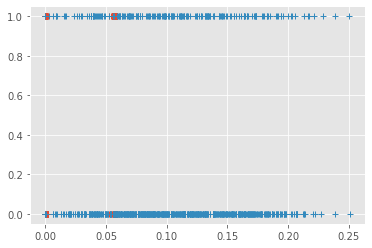

In [41]:
plt.plot(sample_train, label_train,'+')

## Hybrid

In [23]:
# Define feature_map

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=num_reps)

# Define the backend
backend = QuantumInstance(
    BasicAer.get_backend("qasm_simulator"), shots=num_shots, seed_simulator=seed, seed_transpiler=seed
)

# Define the kernel

kernel = QuantumKernel(feature_map=feature_map, quantum_instance=backend)

# Model run
svc = SVC(kernel=kernel.evaluate)
svc.fit(sample_train, label_train)
score = svc.score(sample_test, label_test)

print(f"Callable kernel classification test score: {score}")

Callable kernel classification test score: 0.775


In [24]:
result_predict = svc.predict(sample_test)

In [25]:
print(metrics.classification_report(label_test,result_predict))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87       155
           1       0.00      0.00      0.00        45

    accuracy                           0.78       200
   macro avg       0.39      0.50      0.44       200
weighted avg       0.60      0.78      0.68       200



/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Classical Approaches

In [34]:
models = []
models.append(('LR', LogisticRegression(max_iter=1000)))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [35]:
df_results = pd.DataFrame()

In [36]:
def evaluate_ml_model(models, X, y, n_fold=10, metric='precision'):
    
    _df = pd.DataFrame()
    #results = []
    names = []
    #scoring = 'accuracy'
    for name, model in models:
        kfold = KFold(n_splits=n_fold)
        cv_results = cross_val_score(model, X, y, cv=kfold, scoring=metric)
        #results.append(cv_results)
        names.append(name)
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        #print(msg)
        _df =  pd.concat([_df, pd.DataFrame([round(100*cv_results.mean(), 2) , round(100*cv_results.std(), 2) ]).T])
    _df.index = names
    _df.columns=[metric+' mean (%)', metric+' std (%)']
    return _df 
             
        

In [37]:
_metrics = ['precision', 'recall', 'f1', 'accuracy', 'balanced_accuracy', 'matthews_corrcoef']
for metric in _metrics:
    df_results= pd.concat([df_results, evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric=metric)], axis=1)

/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/homebrew/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is i

In [38]:
df_results= pd.concat([df_results, evaluate_ml_model(models, sample_train, label_train, n_fold=10, metric='accuracy')], axis=1)

In [39]:
df_results

,precision mean (%),precision std (%),recall mean (%),recall std (%),f1 mean (%),f1 std (%),accuracy mean (%),accuracy std (%),balanced_accuracy mean (%),balanced_accuracy std (%),matthews_corrcoef mean (%),matthews_corrcoef std (%),accuracy mean (%),accuracy std (%)
LR,0.00,0.00,0.00,0.00,0.00,0.00,75.25,4.50,50.00,0.00,0.00,0.00,75.25,4.50
KNN,32.34,27.65,13.26,9.68,17.60,12.40,70.62,6.78,51.33,5.47,4.38,17.18,70.62,6.78
CART,31.79,6.81,33.16,12.18,33.08,8.68,67.38,4.79,55.41,5.59,12.05,12.05,67.12,4.33
NB,0.00,0.00,0.00,0.00,0.00,0.00,75.25,4.50,50.00,0.00,0.00,0.00,75.25,4.50
SVM,0.00,0.00,0.00,0.00,0.00,0.00,75.25,4.50,50.00,0.00,0.00,0.00,75.25,4.50


## QSVC

In [ ]:
# Be assure that your qiskit version is 0.4.0
# run !pip install --upgrade qiskit==0.4.0 if not 

In [28]:
%%script false --no-raise-error
# Define feature_map, optimizer and var_form

feature_map = ZZFeatureMap(feature_dimension=feature_dim, reps=2)
optimizer = COBYLA(maxiter=20, disp=True, rhobeg=1.0, tol=None)
var_form = TwoLocal(feature_dim, ['ry', 'rz'], 'cz', reps=3)


# Define the backend

backend = qiskit.Aer.get_backend('qasm_simulator')

# Define the instance

quantum_instance = QuantumInstance(backend, shots=1024, seed_simulator=seed, seed_transpiler=seed)

# Model run
vqc = QSVC(quantum_kernel=quantum_instance)#optimizer, feature_map, var_form, training_input, test_input, datapoints[0])


result = vqc.fit(sample_train, label_train)



AttributeError: 'QuantumInstance' object has no attribute 'evaluate'

In [1]:
import qiskit
qiskit.__version__

'0.21.1'

In [33]:
!pip3 install --upgrade qiskit #==0.4.0

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


## Pennylane

In [45]:
from pennylane import numpy as np

In [46]:
# Angle Encoding

num_qubits = n_dim

dev = qml.device('default.qubit', wires = num_qubits)

@qml.qnode(dev)
def circuit(parameters, data):
    for i in range(num_qubits):
        qml.Hadamard(wires = i)
    
    AngleEmbedding(features = data, wires = range(num_qubits), rotation = 'Y')
    
    qml.StronglyEntanglingLayers(weights = parameters, wires = range(num_qubits))
    
    return qml.expval(qml.PauliZ(0))

In [47]:
num_layers = 5
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

#print(weights_init, bias_init)

In [48]:
circuit(weights_init, sample_train[0])

KeyError: 0

In [ ]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

In [ ]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In [ ]:
def accuracy(labels, predictions):

    loss = 0
    for l, p in zip(labels, predictions):
        if abs(l - p) < 1e-5:
            loss = loss + 1
    loss = loss / len(labels)

    return loss

In [ ]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

In [ ]:
Y = np.array(label_train * 2 - np.ones(len(label_train)),requires_grad=True)  # shift label from {0, 1} to {-1, 1}
X = np.array(sample_train, requires_grad=True)

for i in range(5):
    print("X = {}, Y = {: d}".format(list(X[i]), int(Y[i])))

In [ ]:
opt = AdamOptimizer(stepsize=0.1, beta1=0.9, beta2=0.99, eps=1e-08)
batch_size = 10

In [ ]:
weights = weights_init
bias = bias_init

wbest = 0
bbest = 0
abest = 0

for it in range(20):

    # weights update by one optimizer step

    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, X_batch, Y_batch)

    # Compute the accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]
    
    '''if accuracy(Y, predictions) > abest:
        wbest = weights
        bbest = bias
        abest = accuracy(Y, predictions)
        print('New best')

    acc = accuracy(Y, predictions)

    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), acc
        )
    )'''
    if metrics.f1_score(Y, predictions, average='binary', pos_label=1) > abest:
        wbest = weights
        bbest = bias
        abest = metrics.f1_score(Y, predictions, average='binary')
        print('New best')
    prec = metrics.f1_score(Y, predictions, average='binary')
    print(
        "Iter: {:5d} | Cost: {:0.7f} | Accuracy: {:0.7f} ".format(
            it + 1, cost(weights, bias, X, Y), prec
        )
    )
    
    

In [ ]:
Yte = np.array(label_test * 2 - np.ones(len(label_test)))
Xte = np.array(normalize(sample_test))

In [ ]:
predictions = [np.sign(variational_classifier(wbest, bbest, x)) for x in Xte]
pred = [np.sign(variational_classifier(wbest, bbest, x)) for x in X]
acc = accuracy(Yte, predictions)

print(f'Cost: {cost(wbest, bbest, Xte, Yte)}, Accuracy: {np.round(acc, 2) * 100}%')

In [ ]:
print(metrics.classification_report(predictions,Yte))

In [ ]:
print(f'''

    Precision: {round(100*metrics.precision_score(predictions,Yte),2)}%
    Recall: {round(100*metrics.recall_score(predictions,Yte),2)}%
    f1: {round(100*metrics.f1_score(predictions,Yte),2)}%
    Accuracy: {round(100*metrics.accuracy_score(predictions,Yte),2)}%
    Balanced accuracy: {round(100*metrics.balanced_accuracy_score(predictions,Yte),2)}%
    Matthew corcorref: {round(100*metrics.matthews_corrcoef(predictions,Yte),2)}%
    ''')